## Index

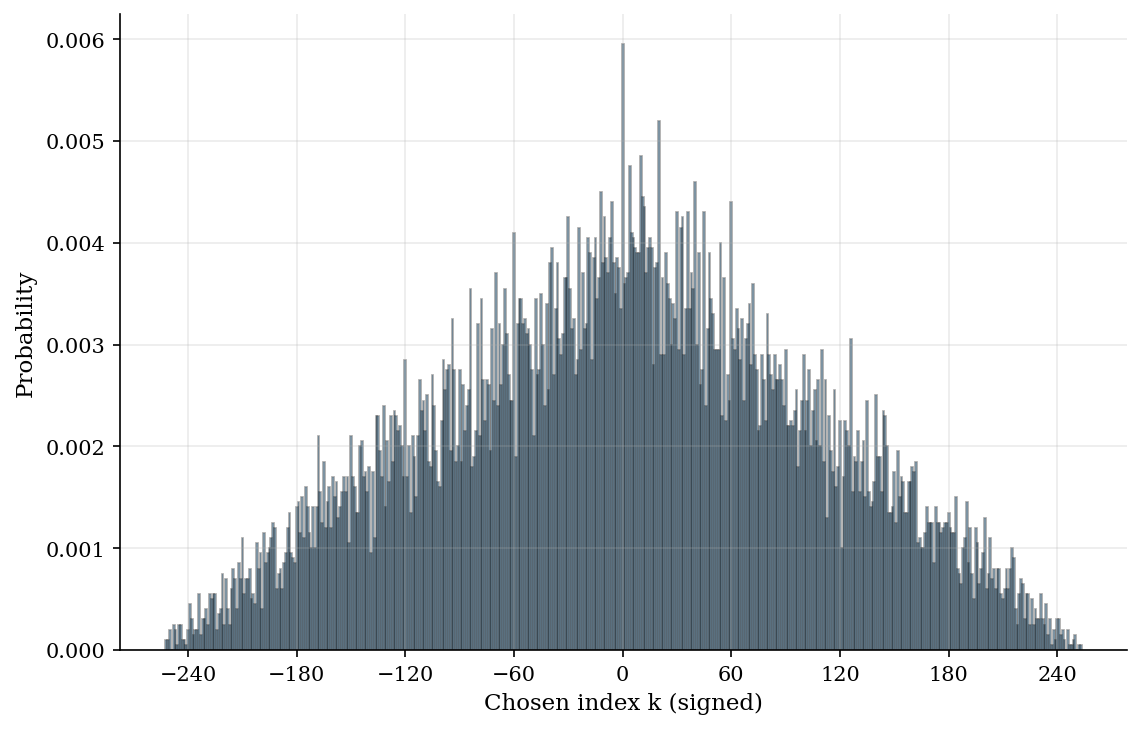

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from nurs import logsumexp2, sub_block_stops_log, apply_perm, sample_uniform, sample_qw, sample_ql
from distance import dist, invert, DIST_NAME_TO_ID

def _apply_pub_style():
    plt.rcParams.update({
        "figure.dpi": 150,
        "savefig.dpi": 300,
        "figure.figsize": (7.5, 4.75),
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": True,
        "grid.alpha": 0.25,
        "axes.labelsize": 11,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.frameon": False,
        "font.family": "serif",
        "mathtext.fontset": "cm",
    })

def nurs_kernel_chosen_index(n, start, beta, eps, max_doublings, rho, dist_id):
    leps = math.log(eps)
    left = start.copy(); right = start.copy(); best = start.copy()
    best_chosen_idx = 0
    tot = -beta * dist(dist_id, start)
    fwd = rho; bwd = invert(fwd)
    lpos = 0; rpos = 0
    perm_buffer = np.empty(n, dtype=np.int64)
    doubling_bits = np.random.randint(0, 2, size=max_doublings)
    for j in range(max_doublings):
        ext = 1 << j
        grow = doubling_bits[j] == 1
        anchor = right if grow else left
        anchor_off = rpos if grow else lpos
        step = fwd if grow else bwd
        perm = anchor.copy()
        ext_logw = np.empty(ext, dtype=np.float64)
        for t in range(ext):
            apply_perm(perm_buffer, perm, step)
            perm, perm_buffer = perm_buffer, perm
            ext_logw[t] = -beta * dist(dist_id, perm)
        if sub_block_stops_log(ext_logw, leps):
            break
        last = perm.copy()
        perm = anchor.copy()
        for t in range(ext):
            apply_perm(perm_buffer, perm, step)
            perm, perm_buffer = perm_buffer, perm
            pos = anchor_off + (t + 1) if grow else anchor_off - (t + 1)
            lw = ext_logw[t]
            nt = logsumexp2(tot, lw)
            if np.random.random() < math.exp(min(0.0, lw - nt)):
                best = perm.copy()
                best_chosen_idx = pos
            tot = nt
        if grow:
            right = last; rpos += ext
        else:
            left = last; lpos -= ext
        if max(-beta * dist(dist_id, left), -beta * dist(dist_id, right)) <= leps + tot:
            break
    return best, best_chosen_idx

def sample_chosen_index_with_draw(n, sigma0, draw_rho, beta, eps, max_doublings, dist_id):
    s0 = np.fromiter(sigma0, dtype=np.int64, count=n)
    rho = draw_rho()
    nxt, chosen_idx = nurs_kernel_chosen_index(n, s0, beta, eps, max_doublings, rho, dist_id)
    return tuple(int(x) for x in nxt), int(chosen_idx)

def run_chain(n, steps, draw_rho, beta, eps, max_doublings, dist_id):
    st = tuple(range(n))
    idxs = np.empty(steps, dtype=np.int64)
    for k in range(steps):
        st, idxs[k] = sample_chosen_index_with_draw(n, st, draw_rho, beta, eps, max_doublings, dist_id)
    return idxs

def make_draw_rho(n, w=None, l=None):
    def _draw():
        if w is not None:
            return sample_qw(n, w)
        elif l is not None:
            return sample_ql(n, l)
        else:
            return sample_uniform(n)
    return _draw

if __name__ == "__main__":
    n = 1000
    beta = 1.0 / n**2
    steps = 20_000
    eps = 1e-3
    max_doublings = 8
    dist_id = DIST_NAME_TO_ID["L2"]
    rng_seed = 0
    np.random.seed(rng_seed)
    w = 15
    l = None
    draw_rho = make_draw_rho(n, w=w, l=l)

    idxs = run_chain(n, steps, draw_rho, beta, eps, max_doublings, dist_id)

    kmin = int(idxs.min())
    kmax = int(idxs.max())
    bins = np.arange(kmin - 0.5, kmax + 1.5, 1)

    _apply_pub_style()
    fig, ax = plt.subplots(constrained_layout=True)
    ax.hist(idxs, bins=bins, density=True, edgecolor="black", linewidth=0.8, alpha=0.35)
    ax.set_xlabel("Chosen index k (signed)")
    ax.set_ylabel("Probability")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()